# Dimensionality Reduction
## Intro
Whereas feature selection is the process of simply filtering out the features you want to use without editing them in any way, **dimensionality reduction** is the process of reducing your total number of features by manipulating them into simpler forms. For example, removing redundant variables (e.g. minutes on the treadmill and calories burned - both indicate the same thing and will be correlated) or combining related variables (e.g. length and width combine to form area).

The below code examples are a combination of feature selection (e.g. high correlation filter, low variance filter) and dimensionlity reduction (factor analysis, PCA) and the distinction is important (i.e. feature selection simply **filters features** without changing them, dimensionality reduction **transforms features into a lower dimension**) and both are included for completeness. There is a further field of feature engineering but we will come onto this in a separate notebook (although some of the below fall somewhat into that category).

Dimensionality reduction can improve your models by:
* **Reducing total number of variables**, hence reducing memory requirements, time taken to run and also effectiveness of models (which sometimes struggle with large numbers of features).
* Remove any issues with **redundant features** (e.g. multi-collinearity of correlated feature variables).
* **Improving overall accuracy** and **reducing overfitting** of models by removing noise in redundant and irrelevant variables.

There are many different methods for performing dimensionality reduction and we will cover a few of them off below.

# 1. Feature Selection
This first group of methods can be broadly categorised as feature selection instead of dimensionality reduction because they are simply filtering features without manipulating or transforming them in any way. We will later come on to dimensionality reduction techniques.

**Project Link:** https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/

## Missing Value (Ratio)
Missing values are one of the first things to look for in the data exploration phase, there are many ways to handle this such as **imputing** (e.g. variable mean), **dropping rows** containing missing values or **dropping the variable** altogether. Below we will identify the proportion of missing values for each variable in our training set and then decide how to proceed.

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# show plots in notebook
%matplotlib inline

# read in data
train_stores = pd.read_csv('train_stores.csv')
test_stores = pd.read_csv('test_stores.csv')
sample_stores = pd.read_csv('sample_submission_stores.csv')

# check proportion of missing samples in training data
train_stores.isnull().sum()/len(train_stores)*100

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

There aren't many missing values in our data, only 2 variables have them and no more than 30% in either. For this example, let's set a threshold of 20% missing values and remove any variables which have more than this (i.e. Outlet_Size).

In [2]:
# loop variables
n_cols = len(train_stores.columns) # number of columns for loop
missing_vals = train_stores.isnull().sum()/len(train_stores)*100 # proportion of missing values
raw_feat = train_stores.columns # original columns
sel_feat = [] # list of columns to keep/select

# iterate through # of columns
for i in range(n_cols):
    # keep values with < 20% missing values
    if missing_vals[i] < 0.2:
        sel_feat.append(raw_feat[i])

Instead of simply dropping the columns with missing values (as we have done above, or at least selected for above), we can **impute values** to fill the missing data. Common methods for doing this involve using the **mean/median/mode** of your variable to fill the missing values, so let's do this below.

In [3]:
# impute values for 'item_weight' (use median) and 'outlet_size' (use mode)
train_stores['Item_Weight'].fillna(train_stores['Item_Weight'].median(), inplace=True)
train_stores['Outlet_Size'].fillna(train_stores['Outlet_Size'].mode()[0], inplace=True)

# check results
train_stores.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## Low Variance Filter
If all of the values in a particular variable were 1 then this variable would tell us nothing about our target variable(s) and therefore should be dropped. This is an extreme example, but it's likely that some variables in your data would have a **very low variance** and therefore be worthy of dropping. As such, we can investigate the variance of our **numeric variables**, set a **threshold variance** and drop any features which fall outside of this range.

In [4]:
train_stores.var()

Item_Weight                  1.786956e+01
Item_Visibility              2.662335e-03
Item_MRP                     3.878184e+03
Outlet_Establishment_Year    7.008637e+01
Item_Outlet_Sales            2.912141e+06
dtype: float64

We can see here that 'Item_Visibility' has a far lower variance than the other features and an incredibly low variance as a standalone, therefore we will drop this from our dataset using the below loop and a threshold of 10% variance.

In [5]:
# extract numeric variables
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # define numeric variables
numeric_df = train_stores.select_dtypes(include=numerics) # extract all numeric vars from df

# loop vars
cols = numeric_df.columns # column names
var = train_stores.var() # column variance
sel_cols = [] # list of columns to keep

# iterate through columns
for i in range(0, len(cols)):
    # set threshold of 10% variance
    if var[i] > 0.1:
        # store selected columns
        sel_cols.append(cols[i])

## High Correlation Filter
Certain algorithms (such as linear and logistic regression) suffer significant performance drops if feature variables are correlated (e.g. 'minutes on treadmill' and 'calories burned' where they are strongly correlated) - this is known as the **multi-collinearity** problem. As such, we can use a simple correlation plot to determine which of our numeric variables are correlated and drop anything above a threshold (**normally > 50%**).

As a good rule of thumb, if two feature variables are correlated, try to **keep the variable with the highest correlation to the target variable** as this will be a **better predictor** in our final model.

In [6]:
train_stores.corr()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.014168,0.024951,0.007739,0.009693
Item_Visibility,-0.014168,1.000000,-0.001315,-0.074834,-0.128625
Item_MRP,0.024951,-0.001315,1.000000,0.005020,0.567574
Outlet_Establishment_Year,0.007739,-0.074834,0.005020,1.000000,-0.049135
Item_Outlet_Sales,0.009693,-0.128625,0.567574,-0.049135,1.000000


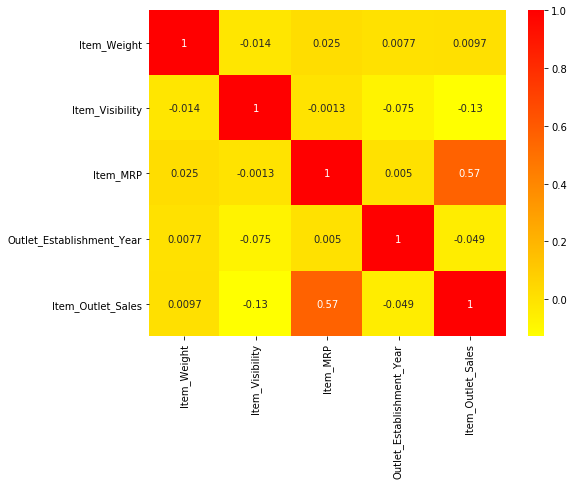

In [7]:
# load libraries
import seaborn as sns

# correlation matrix of train numeric variables
corr = train_stores.corr()

# plot in heatmap
plt.figure(figsize=(8, 6)) # define plot size
sns.heatmap(corr, annot=True, cmap='autumn_r') # heatmap with labels and colour
plt.show() # show plot

The only variables with a reasonably high correlation (~>50%) are 'Item_Outlet_Sales' and 'Item_MRP', however in our previous step of **low variance filtering** we decided that 'Item_Outlet_Sales' had a lower than desired variance anyway, so we will drop this from our dataset. No other variables have a significant correlation so we can continue.

'Item_Outlet_Sales' is also the target variable we will be measuring so that's another reason to exclude it as it shouldn't be considered along with our features.

In [8]:
# drop Item_Outlet_Sales due to low variance
X_train = train_stores.drop('Item_Outlet_Sales', 1)

## Random Forest
This method is very commonly used and builds a layered model (# of layers = depth) to determine which features are the most important in the model's accuracy. Random forests are **ensemble learning** methods because they combine multiple decision trees in an attempt to overcome the individual **decision tree's habit for overfitting**. Random forest can be used for either classification or regression, returning the **mode class for classification problems and the mean prediction for regression**.

RandomForestRegressor has **in-built feature importance** calculations so you can utilise this rather than running it yourself. RandomForest only takes numeric inputs (as do many other algorithms) therefore we must use **OneHotEncoding** to convert our categorical variables into binary numeric variables before running the model. Also, we will drop our ID variables as these hold no meaning in relation to our target variable **Item_Outlet_Sales**.

In [9]:
# load libraries
from sklearn.ensemble import RandomForestRegressor

# extract target variable
y_train = train_stores['Item_Outlet_Sales']

# drop ID variables (not relevant for prediction)
X_train = X_train.drop(['Item_Identifier', 'Outlet_Identifier'], 1)

# create dummy variables for categorical vars (i.e. OneHotEncoding)
X_train_enc = pd.get_dummies(X_train) # only affects categorical vars

# build RF model
model = RandomForestRegressor(random_state=1, max_depth=10) # max_depth = levels of RF

# fit model
model.fit(X_train_enc, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

We use the **get_dummies()** method from Pandas to automatically convert our categorical variables into binary features for use in our model. Then it's just a case of instantiating our RF model with a max_depth of 10 (maximum levels in each tree) and fit it to our training data.

Now we can visualize our feature importances and use this to decide which ones to take forward in our analysis.

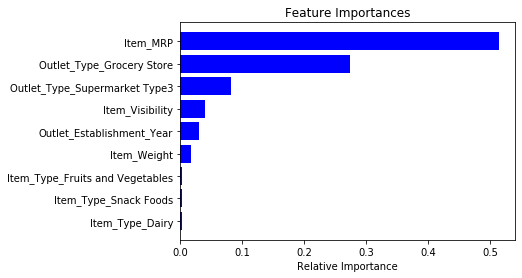

In [10]:
# get feature names
features = X_train_enc.columns

# get feature importance scores
importances = model.feature_importances_

# return top 10 features by importance
indices = np.argsort(importances)[-9:] # gets index of each value

# plot feature importances as histogram
plt.title('Feature Importances') # title
plt.barh(range(len(indices)), importances[indices], color='b', align='center') # y-axis position, width/size of bars
plt.yticks(range(len(indices)), [features[i] for i in indices]) # use index of values to extract relevant feature label
plt.xlabel('Relative Importance') # x axis label
plt.show() # show plot

Clearly we can see a number of the most important features in our dataset and begin to have an idea of which to include going forwards.

We can then use the **SelectFromModel()** function to extract the variables that our above random forest regressor has determined to be the most useful. You can see that the below outputs a set of feature values with 5 features present, hence it has determined 5 features to use from our original dataset.

In [11]:
# load libraries
from sklearn.feature_selection import SelectFromModel

# extract most important features from data
sfm = SelectFromModel(model) # using the random forest regressor we built previously
ext_feat = sfm.fit_transform(X_train_enc, y_train)

# show new shape
ext_feat.shape

(8523, 5)

## Backward Feature Elimination
This method follows these steps:
* Build a model using all features
* Calculate the accuracy of the model
* Remove one feature at a time and calculate the model accuracy each time
* Whichever feature caused the biggest drop in model accuracy (or the smallest change full stop) is removed
* This is done iteratively until no more features can be removed (either reached a threshold model accuracy or number of features)

**NOTE:** this method is great for both **linear** and **logistic regression** problems.

In [12]:
# load libraries
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn import datasets

# build linear regression object
regr = LinearRegression()

# build RFE, specifying 10 features in output dataset
rfe = RFE(regr, 10)

# apply to cut original features down to just 10 most important
X_train_rfe = rfe.fit_transform(X_train_enc, y_train)

# check output shape (should be 10 columns)
X_train_rfe.shape

# can check 'rfe.support_', 'rfe.ranking_' etc. for RFE parameters

(8523, 10)

## Forward Feature Selection
This process is essentially the opposite of backwards feature elimination:
* Add one feature at a time and calculate the model accuracy
* Pick the feature which improves the accuracy the most
* Iteratively continue this process until all features are added or model accuracy does not increase

In [13]:
# load libraries
from sklearn.feature_selection import f_regression

# build model
ffs = f_regression(X_train_enc, y_train)

# list of vars to keep
variable = [ ]

# iterate through features
for i in range(0,len(X_train.columns)-1):
    # keep features with an F-value > 10
    if ffs[0][i] >= 10:
       variable.append(X_train.columns[i])
    
# print selected features
variable

['Item_Fat_Content', 'Item_Visibility', 'Item_Type']

The **forward feature selection** method calculates an **F-score and a p-value** to determine how significant the relationships between our features and target variables are. The F-score and p-value should be looked at in combination to determine whether or not our results are significant and then we can place a threshold (10 in the above example) to determine **which features are significant enough to keep**.

More details on F-scores: https://www.statisticshowto.com/probability-and-statistics/f-statistic-value-test/

It should be noted that both backward elimination and forward feature selection methods are **computationally expensive** and should only be used on **small numbers of features (e.g. <=20)**.

# 2. Dimensionality Reduction
## Factor Analysis
This method identifies correlations between feature variables and groups them so that each group (or **factor**) contains features which are **correlated to each other but not any other factor**. The benefit of this is that instead of your initial large number of features, by grouping correlated features together you end up with **fewer factors**. An example of this could be height and weight, not identical in value but certainly likely to be correlated.

**Project Link:**
* https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/

**Pillow Image Reading Tutorials:**
* https://machinelearningmastery.com/how-to-load-and-manipulate-images-for-deep-learning-in-python-with-pil-pillow/
* https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays

In [14]:
# load libraries
import glob # finds files in paths in custom ways (e.g. lots at once)
import PIL # pillow - image reading library
import copy # enables me to copy images to prevent "too many files open" issue with pillow
from numpy import asarray # convert image to array

# input path
in_path = 'C:/Users/Matthew.Allen2/Desktop/Data Science/Dimensionality Reduction/train/train/'

# load images
#images = [PIL.Image.open(file) for file in glob(in_path + '*.png')]

# load images (creates copy of files to avoid "too many files open" error)
images = []
images_arr = []

# iterate through images
for file in glob.glob(in_path + '*.png'):
    # copy file (avoid open error)
    keep = copy.deepcopy(PIL.Image.open(file))
    
    # convert pngimagefile to np.array
    image_arr = asarray(keep)
    
    # append to lists
    images.append(keep)
    images_arr.append(image_arr)

Now that we've loaded our images into memory, we must convert them into numpy arrays so that we can use their pixel/numerical values for the models we will run (as models like numbers over other formats).

In [15]:
# convert images into numpy array
img = asarray(images_arr)

# check shape
img.shape

(60000, 28, 28, 4)

As you can see, this numpy array is multi-dimensional, therefore we must flatten it to 1D so that it fits our models which require this format.

In [16]:
# create empty list
image = []

# iterate through images
for i in range(0, img.shape[0]):
    # flatten from 3D to 1D
    images = img[i].flatten()
    image.append(images)
    
# convert to numpy array
image = np.array(image)

# check output shape
image.shape

(60000, 3136)

We can now load our pixel data for each image into a dataframe where rows are images and columns are the different pixels in each image. We will combine this data with the known labels (i.e. whether or not an image is apparel) from our training data CSV.

In [17]:
# path to labels file
in_path = 'C:/Users/Matthew.Allen2/Desktop/Data Science/Dimensionality Reduction/train/'

# load training labels (i.e. known outputs)
train = pd.read_csv(in_path + 'train.csv')

# build df of pixels per image
feat_cols = [ 'pixel' + str(i) for i in range(image.shape[1])] # create cols called pixel1, pixel2 etc.
df = pd.DataFrame(image, columns = feat_cols) # load image pixel values (black/white here) into rows and cols
df['label'] = train['label'] # add label/target variable

# peek at data
df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel3127,pixel3128,pixel3129,pixel3130,pixel3131,pixel3132,pixel3133,pixel3134,pixel3135,label
0,0,0,0,255,0,0,0,255,0,0,...,255,0,0,0,255,0,0,0,255,9
1,0,0,0,255,0,0,0,255,0,0,...,255,0,0,0,255,0,0,0,255,0
2,0,0,0,255,0,0,0,255,0,0,...,255,0,0,0,255,0,0,0,255,0
3,0,0,0,255,0,0,0,255,0,0,...,255,0,0,0,255,0,0,0,255,3
4,0,0,0,255,0,0,0,255,0,0,...,255,0,0,0,255,0,0,0,255,0


We will run our **factor analysis** on this dataframe in order to group our features into factors which contain similar (correlated) features. There's a lot that goes on behind the scenes in this algorithm and the method used depends on your dataset (e.g. OLS for images, PCA for linear regressions...) but it basically works by identifying features with the **most variance** and putting them into separate factors until it's filled each factor (specified by **n_components**) and then groups the **most correlated/lowest variance** features together until there are none left.

The final output (which will have significantly reduced dimensions, e.g. 3 columns if n_components=3) is a **score** which represents the combination of all features inside each factor and this score can be used for the model going forwards as a **dimensionally reduced format** compared to the original dataframe with all feature values.

**Useful Links:**
* SKLearn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html
* Factor analysis overview: https://www.statisticssolutions.com/factor-analysis-sem-factor-analysis/#:~:text=Factor%20analysis%20is%20a%20technique,this%20score%20for%20further%20analysis.

In [18]:
# load libraries
from sklearn.decomposition import FactorAnalysis

# apply factor analysis to features
FA = FactorAnalysis(n_components = 3).fit_transform(df[feat_cols].values) # n_components groups features into 3 factors

# check output (should be 3 factors to match n_components)
FA.shape

(60000, 3)

We can now visualize our results, as you can see the values no longer correspond to the raw pixel values we loaded in, instead they are the transformed factor values. The three factors have been separated by colour and you can see a general patter in each which differentiates them from one another.

More reading is needed to fully interpret the process and results of factor analysis, useful links for this include:
* Interpreting results: https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/multivariate/how-to/factor-analysis/interpret-the-results/key-results/
* Detailed overview: https://stats.idre.ucla.edu/spss/seminars/introduction-to-factor-analysis/a-practical-introduction-to-factor-analysis/

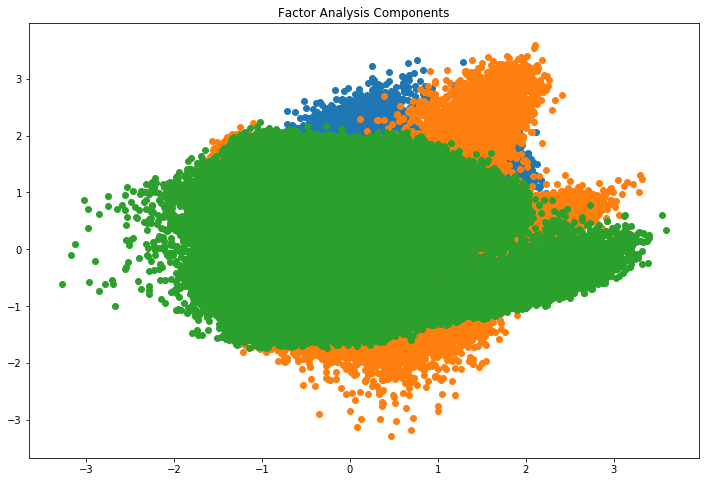

In [19]:
# scatter plot of results
plt.figure(figsize=(12,8))
plt.title('Factor Analysis Components')
plt.scatter(FA[:,0], FA[:,1])
plt.scatter(FA[:,1], FA[:,2])
plt.scatter(FA[:,2],FA[:,0])

## Principal Component Analysis
### Theory
PCA is a process designed to convert **high dimensional data to lower dimensions** (often 3D or more down to 2D) by **removing redundant features** and combining remaining features in a **linear combination**. It works by **capturing the highest variance features** initially in the principal component and then moving onto the second, third etc. components capturing sequentially less variance each time. Finally, you end up with lower dimensional data that can be plotted on a 2D plot whereas previously it would have been very difficult to visualize the relationships between features.

It combines the original features in a linear way, essentially converting multiple dimensional data (e.g. 3D or more) into a 2D plot, it then uses a linear model (**almost a linear regression, drawing a line through the data**) to minimize the error between the linear model and the reduced dimension data points. The first/principal component explains the highest variance between features (e.g. **for an image, it would extract the features/pixels with the highest variance/contrast to best explain the data**). The principal component captures the highest variance features in the data and then moves onto the second component, which captures the next highest variance. The key here is that each subsequent component displays 0 correlation (i.e. is orthogonal/90 degrees) to the previous component and therefore on the 2D plot would appear as a data cluster at 90 degrees to the previous component. This is how the model uses variance to distinguish groups of key features into distinct components and remove redundancy of variables.

Note that the input data for PCA **must be normalized** with a mean of 0 and unit variance/std. of 1. This is because **PCA works by looking at feature variance** and if you have data with drastically different scales (e.g. miles ranging from 0 to 100000 and age from 0 to 80) then the variables with higher unit variance will be unfairly prioritised when in fact, the standardized variance would be the most important in determining relationships in your data.

**Detailed Notes:** https://www.analyticsvidhya.com/blog/2016/03/pca-practical-guide-principal-component-analysis-python/

### Example
We will begin by randomly plotting a few of our images to demonstrate what they look like raw (i.e. before PCA).

<Figure size 432x288 with 0 Axes>

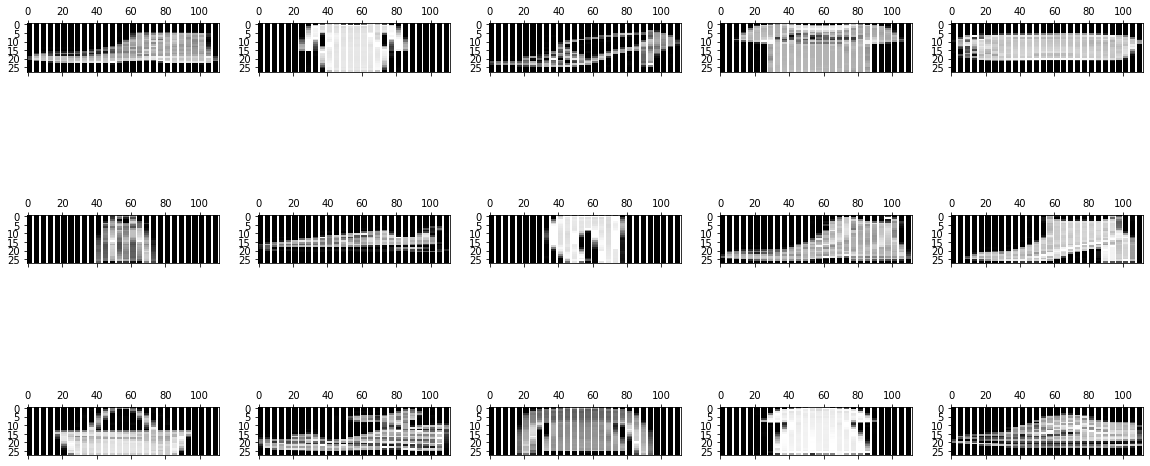

In [34]:
# random value generation
rndperm = np.random.permutation(df.shape[0])

# define plot colour scale
plt.gray()

# create figure
fig = plt.figure(figsize=(20,10))

# plot randomly selected, resized images from all images
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1)
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28*4)).astype(float))

We can now build our PCA model, defining 4 components that we want to end up with (i.e. compress our original features down into 4 new groups/features where each component aims to explain the highest feature variance left in the dataset).

We then plot our results, showing both cumulative variance and component-wise variance (i.e. variance explained by each distinct component).

Text(0.5, 1.0, 'Component-wise and Cumulative Explained Variance')

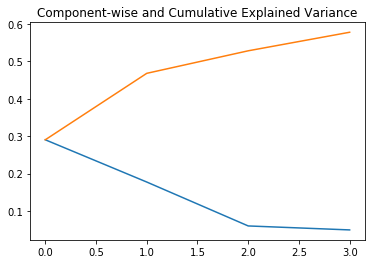

In [35]:
# load libraries
from sklearn.decomposition import PCA

# create pca object, define 4 components (i.e. compress features into 4 groups)
pca = PCA(n_components=4)

# fit and apply model to data (all pixel columns)
pca_result = pca.fit_transform(df[feat_cols].values)

# plot data
plt.plot(range(4), pca.explained_variance_ratio_) # component-wise variance
plt.plot(range(4), np.cumsum(pca.explained_variance_ratio_)) # cumulative variance
plt.title("Component-wise and Cumulative Explained Variance")

As you can see, **we are able to explain ~60% of our dataset's variance with 4 components**. We can go even further and visualize each of our decomposed components as images to understand exactly what is happening here.

Text(0.5, 0.98, '4-Component PCA')

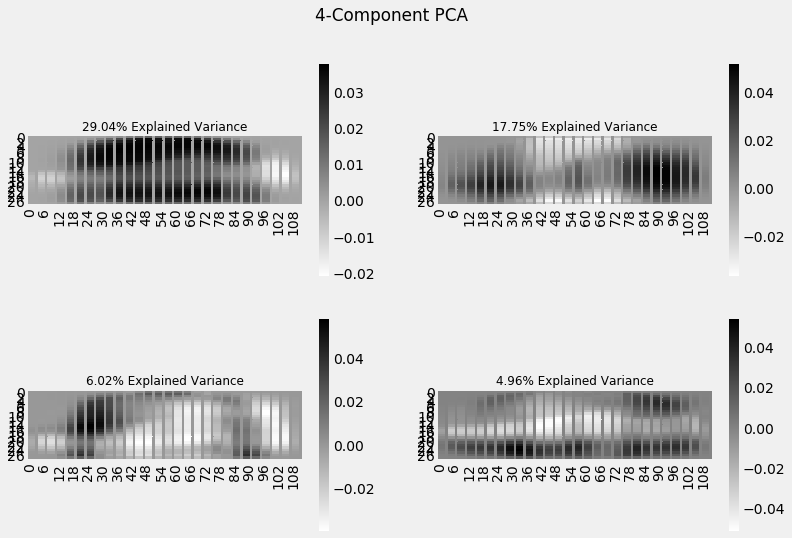

In [37]:
# load libraries
import seaborn as sns

# plot images following PCA dimensionality reduction
plt.style.use('fivethirtyeight') # choose style
fig, axarr = plt.subplots(2, 2, figsize=(12, 8)) # define figure
sns.heatmap(pca.components_[0, :].reshape(28, 28*4), ax=axarr[0][0], cmap='gray_r') # plot each component (this is 1)
sns.heatmap(pca.components_[1, :].reshape(28, 28*4), ax=axarr[0][1], cmap='gray_r') # component 2
sns.heatmap(pca.components_[2, :].reshape(28, 28*4), ax=axarr[1][0], cmap='gray_r') # component 3
sns.heatmap(pca.components_[3, :].reshape(28, 28*4), ax=axarr[1][1], cmap='gray_r') # component 4

# component 1 title
axarr[0][0].set_title(
"{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[0]*100),
fontsize=12
)

# component 2 title
axarr[0][1].set_title(
"{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[1]*100),
fontsize=12
)

# component 3 title
axarr[1][0].set_title(
"{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[2]*100),
fontsize=12
)

# component 4 title
axarr[1][1].set_title(
"{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[3]*100),
fontsize=12
)

# adjust aspect ratio
axarr[0][0].set_aspect('equal')
axarr[0][1].set_aspect('equal')
axarr[1][0].set_aspect('equal')
axarr[1][1].set_aspect('equal')

# add plot title
plt.suptitle('4-Component PCA')

The above might look a bit funky, but here's what's going on:
* Our PCA model converted our original large number of features into 4 components (groups) of features where each component extracts features with the highest variance in the remaining dataset (with component 1 picking the highest variance features, component 2 picking next highest etc.).
* In practical terms, this means that component 1 (i.e. top left in above plot) is showing the pixels which show the highest contrast to each other, so it's lots of blacks and whites around the border and most distinctive areas of the image.
* component 2 (top right) then picks the highest contrasting pixels from the remaining pixels which haven't been selected in component 1 and show no correlation to component 1.
* This continues for components 3 and 4 as well.
* Essentially, PCA is explaining and defining our original image (which began life as a huge, complex array of numeric data for every pixel) in the most concise way possible by grouping features of highest variance to one another.

We can now use **Singular Value Decomposition (SVD)** to apply our PCA model to our original dataset in order to reduce the number of features and remove redundant features, producing a smaller and more relevant dataset which can be used in the remainder of the ML pipeline. There's a lot of technical, statistical stuff going on behind the scenes here, so read through the link below for further detail.

**SVD Explanation:** https://www.analyticsvidhya.com/blog/2017/05/comprehensive-guide-to-linear-algebra/

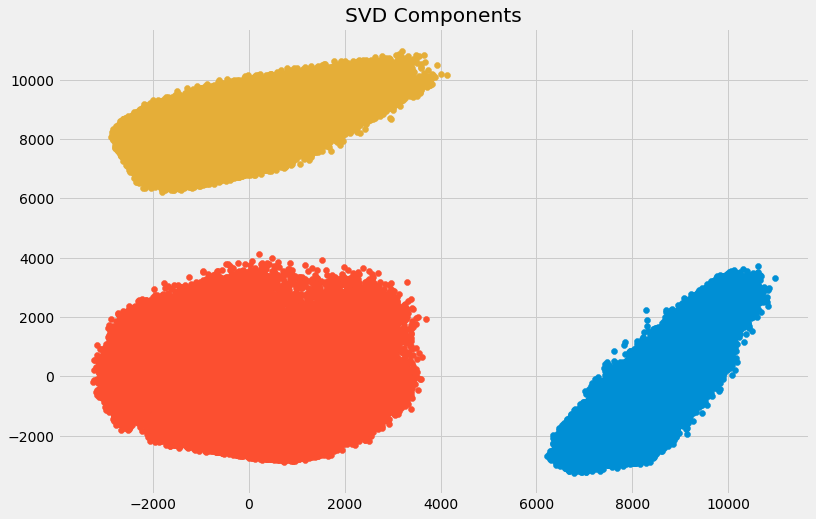

In [38]:
# load libraries
from sklearn.decomposition import TruncatedSVD

# build SVD object and apply to dataset (condensing matrix into 3 sections/components)
svd = TruncatedSVD(n_components=3, random_state=42).fit_transform(df[feat_cols].values)

# plot results
plt.figure(figsize=(12,8))
plt.title('SVD Components')
plt.scatter(svd[:,0], svd[:,1])
plt.scatter(svd[:,1], svd[:,2])
plt.scatter(svd[:,2],svd[:,0])

Again, there's a lot going on behind the scenes here in the SVD object, but for practical purposes, the above plot shows our original dataset split out into it's distinct components. The idea here being that our PCA model identified features/pixels with the highest variance and grouped them together. One key point here is that each component **shows no correlation to another** one and as a result, each one is plotted **orthogonaly (i.e. at right-angles)** to one another.

## NOTE TO SELF
There are more dimensionality reduction methods on this link (below) and they start to use more and more complex statistics. Return here when I've done a little more reading behind the scenes and gone into more detail in this area.

https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/